# Basic data processing

In [59]:
import os
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from enum import Enum
from dataclasses import dataclass
from spacepy import pycdf

In [31]:
sns.set_theme(style="ticks")

## Loading data from ftp server
Place your `FTP_PASSWORD` and download data from the ftp server. If the password contains special characters remember to escape them with `\`.

In [2]:
!mkdir data

In [3]:
!wget -r --user=ifjagh --password=FTP_PASSWORD ftp://ftptrans.psi.ch/to_radem/ -nd -np -P ../data/

--2024-02-18 21:26:02--  ftp://ftptrans.psi.ch/to_radem/
           => ‘../data/.listing’
Resolving ftptrans.psi.ch (ftptrans.psi.ch)... 192.33.120.71
Connecting to ftptrans.psi.ch (ftptrans.psi.ch)|192.33.120.71|:21... connected.
Logging in as ifjagh ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /to_radem ... done.
==> PASV ... done.    ==> LIST ... done.

.listing                [ <=>                ]  33.74K  --.-KB/s    in 0.05s   

2024-02-18 21:26:03 (683 KB/s) - ‘../data/.listing’ saved [34547]

Removed ‘../data/.listing’.
--2024-02-18 21:26:03--  ftp://ftptrans.psi.ch/to_radem/Bard%20timeline-review-Oct-2022%20(1).xlsx
           => ‘../data/Bard timeline-review-Oct-2022 (1).xlsx’
==> CWD not required.
==> PASV ... done.    ==> RETR Bard timeline-review-Oct-2022 (1).xlsx ... done.
Length: 21543 (21K)

Bard timeline-revie 100%[===================>]  21.04K  --.-KB/s    in 0.04s   

2024-02-18 21:26:03 (484 KB/s) - ‘../data/Bard timeline

## Extracting `.tar.gz` files

In [4]:
# Extracts all tar files from data/ directory
!for f in ../data/*.tar.gz; do tar -xvf "$f" -C ../data/; done;

juicepsa-pds4-PI-01-juice_rad-20230416T180019/juice_rad/data_raw/rad_raw_sc_20230416.lblx
juicepsa-pds4-PI-01-juice_rad-20230416T180019/juice_rad/data_raw/rad_raw_sc_20230416.cdf
juicepsa-pds4-PI-01-juice_rad-20230416T180019/juicepsa-pds4-PI-01-juice_rad-20230416T180019-checksum_manifest.tab
juicepsa-pds4-PI-01-juice_rad-20230416T180019/juicepsa-pds4-PI-01-juice_rad-20230416T180019-transfer_manifest.tab
juicepsa-pds4-PI-01-juice_rad-20230416T180019/juicepsa-pds4-PI-01-juice_rad-20230416T180019.xml
juicepsa-pds4-PI-01-juice_rad-20230419T213312/juice_rad/data_raw/rad_raw_sc_20230418.lblx
juicepsa-pds4-PI-01-juice_rad-20230419T213312/juice_rad/data_raw/rad_raw_sc_20230418.cdf
juicepsa-pds4-PI-01-juice_rad-20230419T213312/juicepsa-pds4-PI-01-juice_rad-20230419T213312-checksum_manifest.tab
juicepsa-pds4-PI-01-juice_rad-20230419T213312/juicepsa-pds4-PI-01-juice_rad-20230419T213312-transfer_manifest.tab
juicepsa-pds4-PI-01-juice_rad-20230419T213312/juicepsa-pds4-PI-01-juice_rad-20230419T21331

In [6]:
# Remove tar.gz files and all non-raw data
!find ../data -maxdepth 1 -type f -delete

In [7]:
for file in os.listdir("../data/"):
    print(os.path.join("../data/", file))

../data/juicepsa-pds4-PI-01-juice_rad-20230416T180019
../data/juicepsa-pds4-PI-01-juice_rad-20230419T213312
../data/juicepsa-pds4-PI-01-juice_rad-20230419T213444
../data/juicepsa-pds4-PI-01-juice_rad-20230421T000051
../data/juicepsa-pds4-PI-01-juice_rad-20230421T000226
../data/juicepsa-pds4-PI-01-juice_rad-20230425T092621
../data/juicepsa-pds4-PI-01-juice_rad-20230426T084435
../data/juicepsa-pds4-PI-01-juice_rad-20230426T084607
../data/juicepsa-pds4-PI-01-juice_rad-20230707T185430
../data/juicepsa-pds4-PI-01-juice_rad-20230709T185431
../data/juicepsa-pds4-PI-01-juice_rad-20230720T153618
../data/juicepsa-pds4-PI-01-juice_rad-20230901T105022
../data/juicepsa-pds4-PI-01-juice_rad-20230912T144122
../data/juicepsa-pds4-PI-01-juice_rad-20230912T144248
../data/juicepsa-pds4-PI-01-juice_rad-20230912T144414
../data/juicepsa-pds4-PI-01-juice_rad-20230912T144541
../data/juicepsa-pds4-PI-01-juice_rad-20230912T144708
../data/juicepsa-pds4-PI-01-juice_rad-20230912T144834
../data/juicepsa-pds4-PI-01-

# Reading raw CDF data 

In [2]:
@dataclass
class RawCDF:
    name: str
    date: datetime
    type: str
    data: pycdf.CDF

In [3]:
def parse_date(filename: str) -> datetime:
    date_string = filename[-12:-4]
    format = '%Y%m%d'
    return datetime.strptime(date_string, format).date()

In [6]:
def parse_type(filename: str) -> str:
    return 'science' if filename[8:10] == 'sc' else 'housekeeping' # FixMe: Non exhaustive match

In [7]:
cdfs = [
    RawCDF(name=path.name,
           date=parse_date(path.name),
           type=parse_type(path.name),
           data=pycdf.CDF(str(path))) 
    for path in pathlib.Path('../data').rglob('*.cdf')
]
science_cdfs = [cdf for cdf in cdfs if cdf.type == 'science']

# Experimentation

In [160]:
cdf = science_cdfs[100].data

In [173]:
print(cdf)

DD: CDF_INT8 [1440, 31]
DD_BINS: CDF_BYTE [31] NRV
ELECTRONS: CDF_INT8 [1440, 9]
ELECTRON_BINS: CDF_BYTE [9] NRV
FLUX: CDF_INT8 [1440, 3]
HI_IONS: CDF_INT8 [1440, 8]
HI_ION_BINS: CDF_BYTE [8] NRV
LABEL_DD: CDF_CHAR*9 [31] NRV
LABEL_ELECTRONS: CDF_CHAR*18 [9] NRV
LABEL_FLUX: CDF_CHAR*4 [3] NRV
LABEL_HI_IONS: CDF_CHAR*18 [8] NRV
LABEL_PROTONS: CDF_CHAR*18 [9] NRV
PROTONS: CDF_INT8 [1440, 9]
PROTON_BINS: CDF_BYTE [9] NRV
RADEM_STATUS: CDF_INT2 [1440]
TID: CDF_INT8 [1440]
TIME_OBT: CDF_CHAR*18 [1440]
TIME_RESOLUTION: CDF_UINT2 [1440]
TIME_UTC: CDF_TIME_TT2000 [1440]


In [177]:
def to_dataframe(cdf: pycdf.CDF) -> pd.DataFrame:
    data = {'time': [], 'bin': [], 'type': [], 'value': []}

    # TODO: Loop abomination
    for electrons, protons, time in zip(list(cdf["ELECTRONS"]), list(cdf["PROTONS"]), list(cdf["TIME_UTC"])):
        for i, (electron, proton) in enumerate(zip(electrons, protons)):
            data['time'].append(time)
            data['bin'].append(i+1)
            data['type'].append('electron')
            data['value'].append(electron)

            data['time'].append(time)
            data['bin'].append(i+1)
            data['type'].append('proton')
            data['value'].append(proton)
                                    
    return pd.DataFrame(data)

In [184]:
df = to_dataframe(cdf)

In [186]:
print(df)

                            time  bin      type  value
0     2023-11-10 00:00:45.108489    1  electron      5
1     2023-11-10 00:00:45.108489    1    proton     24
2     2023-11-10 00:00:45.108489    2  electron     17
3     2023-11-10 00:00:45.108489    2    proton    178
4     2023-11-10 00:00:45.108489    3  electron      5
...                          ...  ...       ...    ...
25915 2023-11-10 23:59:47.518826    7    proton     25
25916 2023-11-10 23:59:47.518826    8  electron    868
25917 2023-11-10 23:59:47.518826    8    proton     20
25918 2023-11-10 23:59:47.518826    9  electron      0
25919 2023-11-10 23:59:47.518826    9    proton      0

[25920 rows x 4 columns]


<Axes: xlabel='time', ylabel='value'>

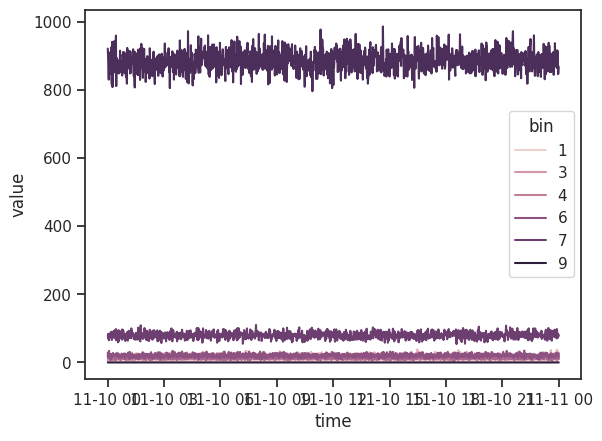

In [189]:
sns.lineplot(data=df[df['type']=='electron'], x='time', y='value', hue='bin')

In [198]:
def plot_combined_bins(df: pd.DataFrame) -> None:
    g = sns.FacetGrid(df, col="type", hue="bin")
    g.map(sns.lineplot, "time", "value", alpha=.7)
    g.add_legend()

In [200]:
def plot_separate_bins(df: pd.DataFrame) -> None:
    g = sns.FacetGrid(df, col="type", row="bin")
    g.map(sns.lineplot, "time", "value", alpha=.7)
    g.add_legend()

## Plot of all 9 channels

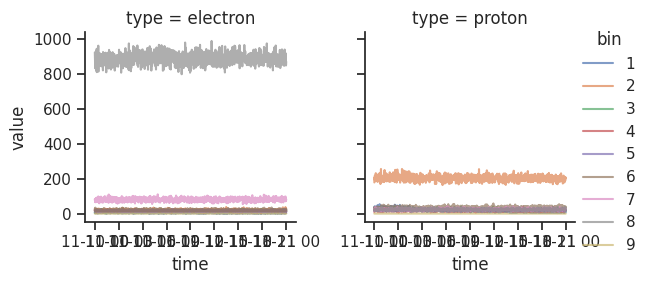

In [199]:
plot_combined_bins(df)

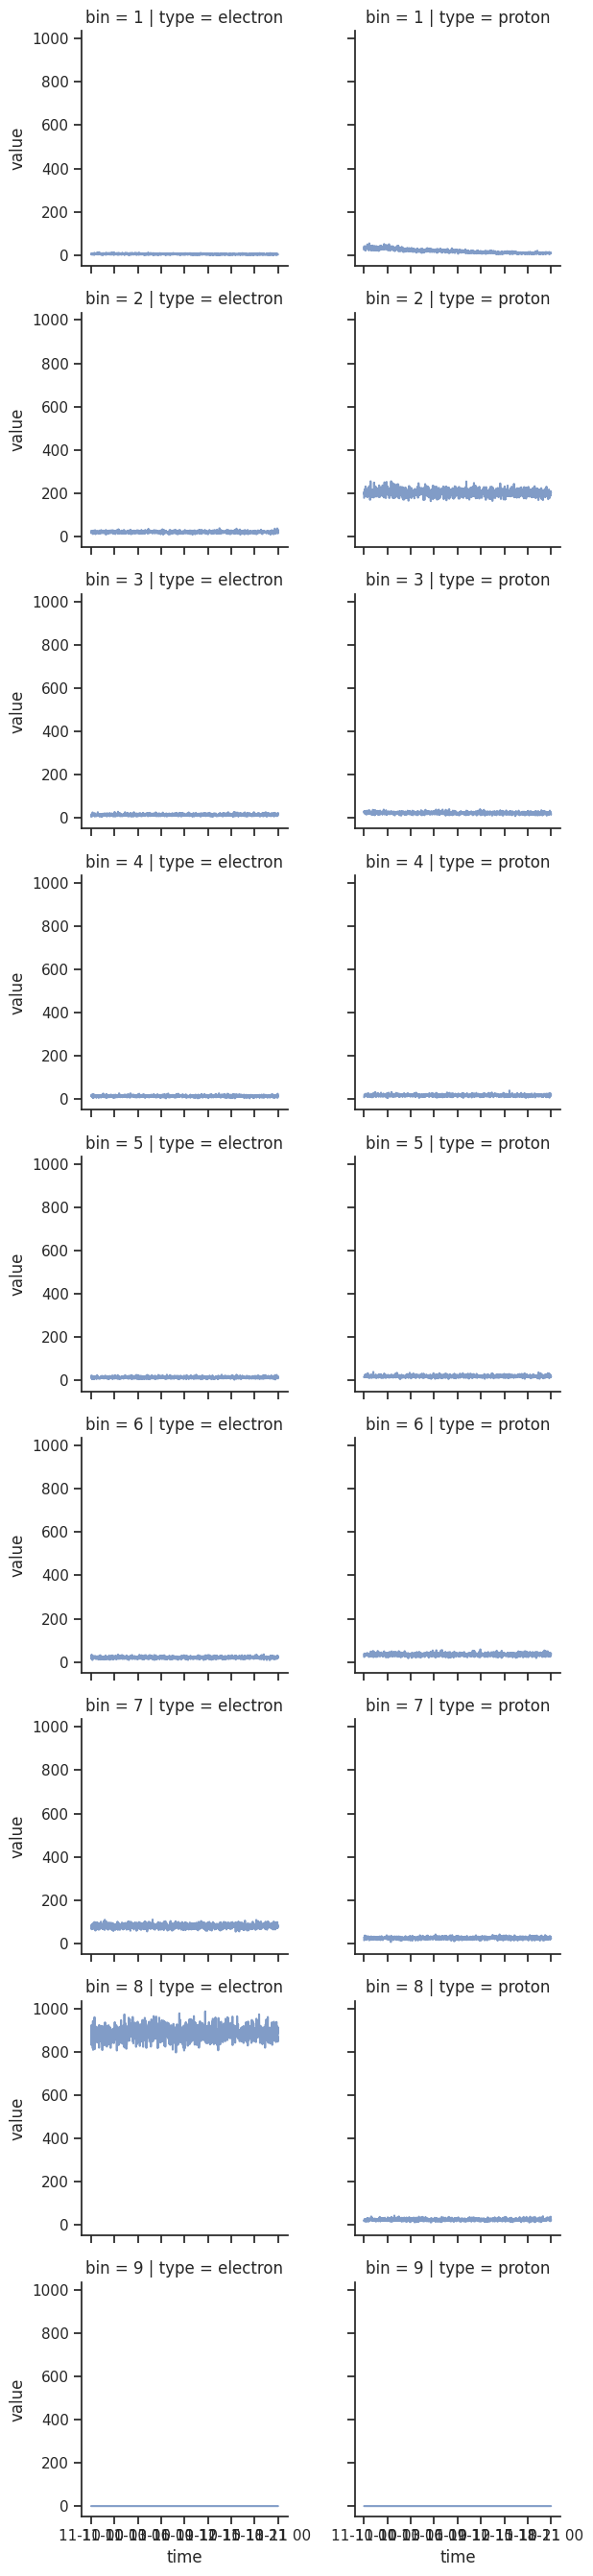

In [201]:
plot_separate_bins(df)

*Note*: Visibly badresults when plotting all bins 